In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # 正常顯示中文標籤
# import matplotlib
# matplotlib.rc('font', family='Microsoft JhengHei')

In [3]:
# 讀取 CSV 文件
dp001_exam = pd.read_csv('2024初賽用開放資料/dp001_exam.csv')
dp001_prac = pd.read_csv('2024初賽用開放資料/dp001_prac.csv')
dp001_review_plus = pd.read_csv('2024初賽用開放資料/dp001_review_plus.csv')
dp001_review = pd.read_csv('2024初賽用開放資料/dp001_review.csv')
dp002_exam = pd.read_csv('2024初賽用開放資料/dp002_exam.csv')
dp003_math = pd.read_csv('2024初賽用開放資料/dp003_math.csv')
dp003_word = pd.read_csv('2024初賽用開放資料/dp003_word.csv')
user_data = pd.read_csv('2024初賽用開放資料/user_data.csv')

user_data

,user_sn,organization_id,grade,class,seat,chinese_score,math_score,english_score
0,2697,973,5,2,12,80,52,86
1,4381,3740,5,7,18,70,52,57
2,4561,973,5,2,16,77,56,100
3,6802,973,5,2,15,93,60,49
4,6828,3740,5,7,27,83,52,89
...,...,...,...,...,...,...,...,...
90,312031,973,5,2,2,80,68,97
91,313378,2486,5,1,7,37,36,34
92,313897,338,5,3,10,73,64,89
93,314389,338,5,3,1,87,68,97


In [14]:
# 有這些科目
dp001_prac['subject_name'].unique()

array(['自然108', '國語文108', '數學108', '數學', nan, '防災', '英語108', '表演藝術',
       '國語文', '音樂', '海洋與環境', '健康與體育', '視覺藝術', '自然', '資訊教育'], dtype=object)

In [51]:
merged_data = pd.merge(dp001_prac, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
filtered_data = merged_data[merged_data['subject_name'].isin(['國語文108', '數學108', '數學', '英語108', '國語文'])]

## 個別科目
- 統整個別user總during_time, 答題數:at_count, 每個問題平均花費時間time_per_question, user_data之科目成績

In [16]:

chinese_data = merged_data[merged_data['subject_name'].isin(['國語文108', '國語文'])] # 篩選國語文科目
chinese_data = chinese_data.assign(at_count=chinese_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = chinese_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')
total_during_time

,user_sn,during_time,at_count,time_per_question,chinese_score
0,4381,495,22.0,22.500000,70
1,4561,37,5.0,7.400000,77
2,6828,538,48.0,11.208333,83
3,11312,167,21.0,7.952381,97
4,14314,456,64.0,7.125000,77
5,23061,278,38.0,7.315789,37
6,23415,1005,45.0,22.333333,23
7,30835,600,64.0,9.375000,73
8,38371,66,12.0,5.500000,37
9,46696,15,2.0,7.500000,67


### Regression Results

In [17]:
X = total_during_time['time_per_question']
y = total_during_time['chinese_score']
X = sm.add_constant(X)  # 增加截距項
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          chinese_score   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.289
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.263
Time:                        11:09:33   Log-Likelihood:                -176.30
No. Observations:                  41   AIC:                             356.6
Df Residuals:                      39   BIC:                             360.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                60.5098      6.89

### 散佈圖，針對time_per_question與user_Data的科目成績

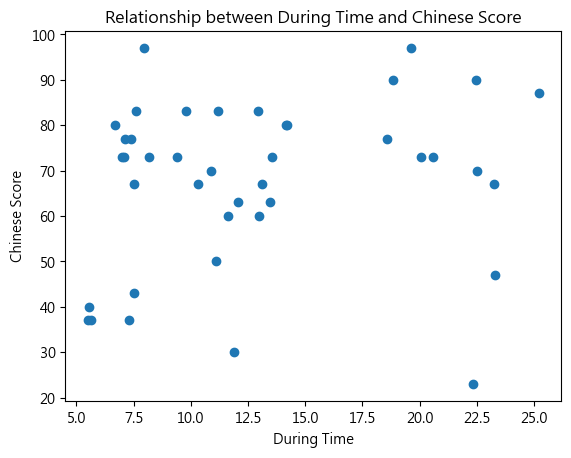

                            OLS Regression Results                            
Dep. Variable:          chinese_score   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.289
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.263
Time:                        11:09:33   Log-Likelihood:                -176.30
No. Observations:                  41   AIC:                             356.6
Df Residuals:                      39   BIC:                             360.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                60.5098      6.89

In [18]:
plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and Chinese Score')
plt.show()

X = total_during_time['time_per_question']
y = total_during_time['chinese_score']
X = sm.add_constant(X)  # 增加截距項
model = sm.OLS(y, X).fit()
print(model.summary())


### 針對英文

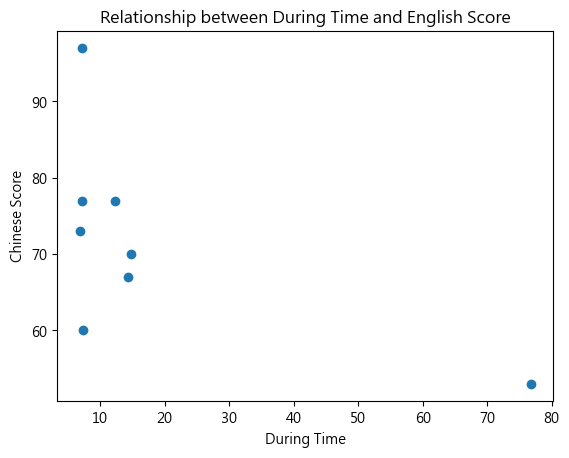

In [19]:
eng_data = merged_data[merged_data['subject_name'].isin(['英語108'])] # 篩選英文文科目
eng_data = eng_data.assign(at_count=eng_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = eng_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')


plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and English Score')
plt.show()

### 針對數學

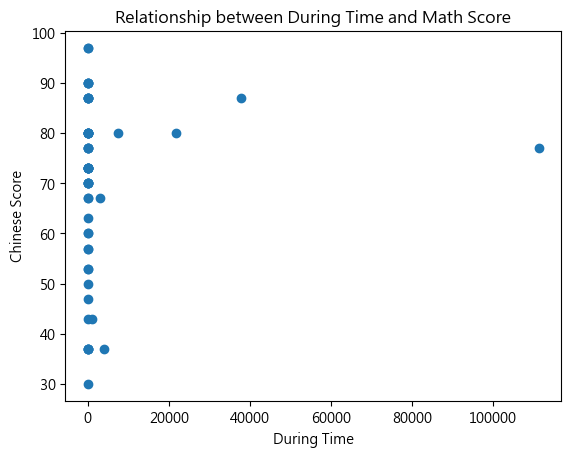

In [20]:
math_data = merged_data[merged_data['subject_name'].isin(['數學108', '數學'])] # 篩選數學文科目
math_data = math_data.assign(at_count=math_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

total_during_time = math_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum'}).reset_index() # 計算總答題數與總作答時間
total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')


plt.scatter(total_during_time['time_per_question'], total_during_time['chinese_score'])
plt.xlabel('During Time')
plt.ylabel('Chinese Score')
plt.title('Relationship between During Time and Math Score')
plt.show()

## "總作答時間"與"score_rate"之間的關係 function

In [21]:
def relationship_between_during_time_and_score_rate(data, subject_name, subject_score): # 繪製作答時間與分數之間的關係
    # subject_data = data[data['subject_name'].isin([subject_name])]
    subject_data = data[data['subject_name'].isin(subject_name)] # 篩選科目
    subject_data = subject_data.assign(at_count=subject_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

    total_during_time = subject_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum', 'score_rate': 'mean'}).reset_index() # 計算總答題數與總作答時間
    total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count'] # 計算平均每題作答時間
    total_during_time = total_during_time.merge(user_data[['user_sn', subject_score]], on='user_sn', how='left') # 合併分數資料
    
    total_during_time = total_during_time[total_during_time['during_time'] < 3000] # 篩選作答時間小於1200的資料


    X = total_during_time['during_time']
    y = total_during_time['score_rate']
    X = sm.add_constant(X)  # 增加截距項
    model = sm.OLS(y, X).fit()
    print(model.summary()) # 顯示迴歸結果
    
    plt.scatter(total_during_time['during_time'], total_during_time['score_rate']) # 繪製散點圖
    plt.xlabel('Total During Time')
    plt.ylabel('Score Rate')
    plt.title(f'Relationship between During Time and Score Rate in {subject_name}')
    plt.show()

# 用不到了
# math_data = merged_data[merged_data['subject_name'].isin(['國語文108', '國語文'])] # 篩選國文科目
# math_data = math_data.assign(at_count=math_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

# total_during_time = math_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum', 'score_rate': 'mean'}).reset_index() # 計算總答題數與總作答時間
# total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count']
# total_during_time = total_during_time.merge(user_data[['user_sn', 'chinese_score']], on='user_sn', how='left')

# # longer_during_time = total_during_time[(total_during_time['during_time'] < 200) & (total_during_time['at_count'] < 20)]

# plt.scatter(total_during_time['during_time'], total_during_time['score_rate'])
# plt.xlabel('Total During Time')
# plt.ylabel('Total Score Rate')
# plt.title('Relationship between During Time and Score Rate in dp001_prac')
# plt.show()
# # total_during_time



                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     13.37
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           0.000752
Time:                        11:09:33   Log-Likelihood:                -174.78
No. Observations:                  41   AIC:                             353.6
Df Residuals:                      39   BIC:                             357.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          55.9589      4.916     11.383      

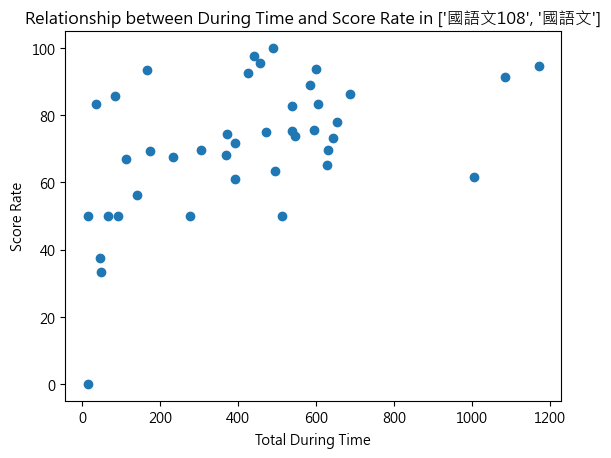

                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7727
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.384
Time:                        11:09:33   Log-Likelihood:                -211.71
No. Observations:                  51   AIC:                             427.4
Df Residuals:                      49   BIC:                             431.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          71.8258      3.668     19.580      

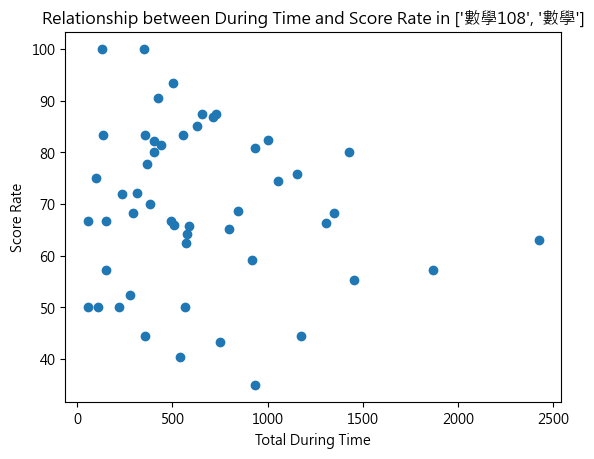

                            OLS Regression Results                            
Dep. Variable:             score_rate   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.7887
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.409
Time:                        11:09:33   Log-Likelihood:                -33.542
No. Observations:                   8   AIC:                             71.08
Df Residuals:                       6   BIC:                             71.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          79.8538      8.938      8.934      

c:\Users\woodfire\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


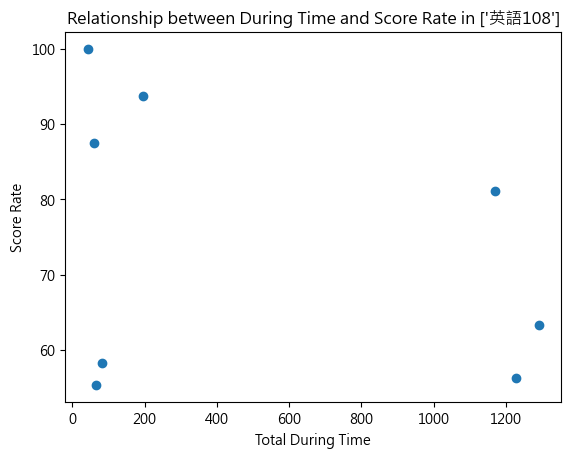

In [22]:
relationship_between_during_time_and_score_rate(merged_data, ['國語文108', '國語文'], 'chinese_score')
relationship_between_during_time_and_score_rate(merged_data, ['數學108', '數學'], 'math_score')
relationship_between_during_time_and_score_rate(merged_data, ['英語108'], 'english_score')

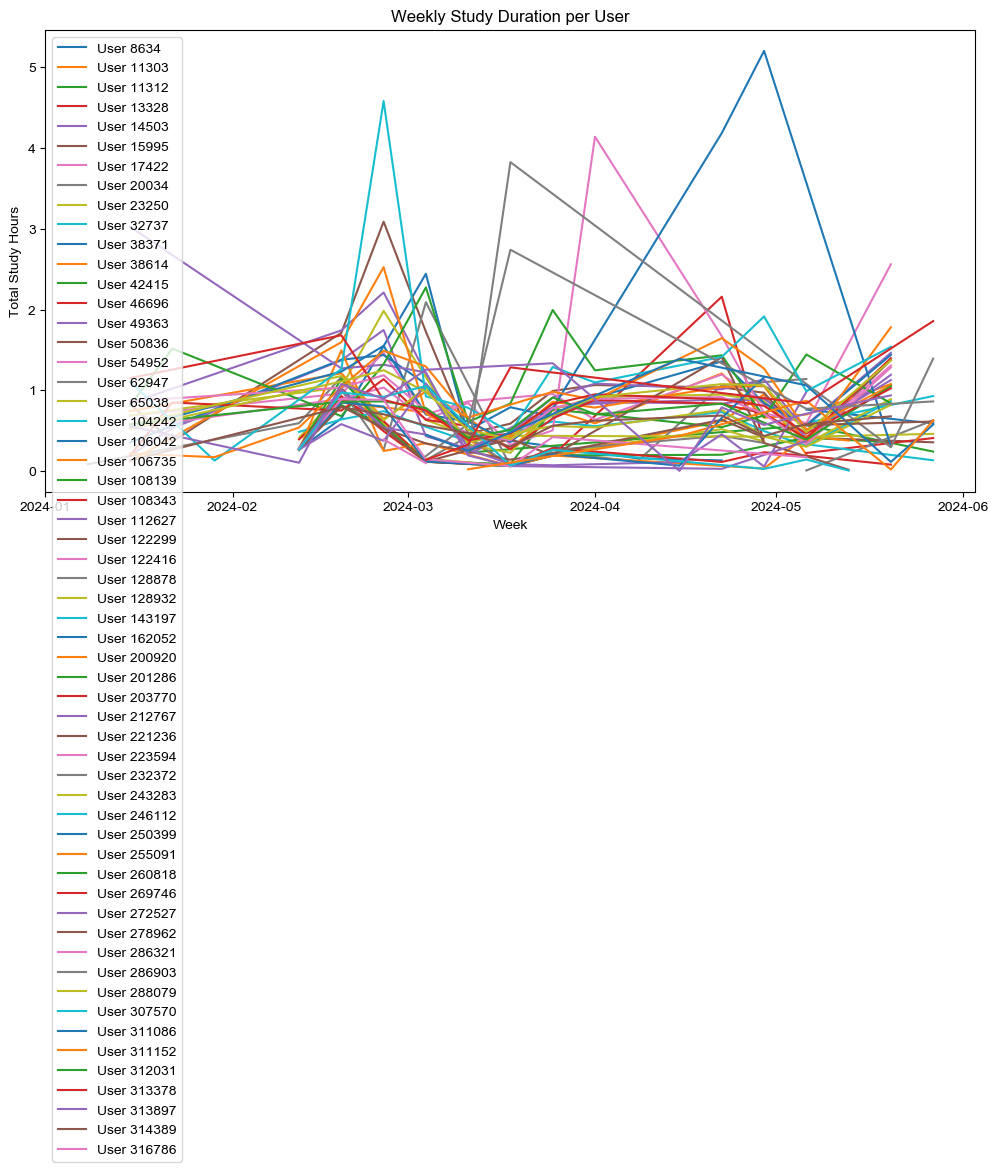

In [62]:

data = duration_per_user_per_date




# # 讀取數據
# data = pd.DataFrame({
#     'user_sn': [8634, 8634, 8634, 8634, 8634, 314389, 314389, 316786, 316786],
#     'date': pd.to_datetime(['2024-02-16', '2024-02-20', '2024-03-04', '2024-03-08', '2024-03-11', '2024-05-07', '2024-05-20', '2024-02-28', '2024-03-10']),
#     'duration': pd.to_timedelta(['0 days 00:16:06', '0 days 00:39:15', '0 days 00:21:33', '0 days 02:05:00', '0 days 00:26:59', '0 days 00:35:00', '0 days 00:21:27', '0 days 00:23:37', '0 days 00:06:03'])
# })

# 計算每週的學習時間
data['week'] = pd.to_datetime(data['date']).dt.to_period('W')
weekly_duration = data.groupby(['user_sn', 'week'])['duration'].sum().reset_index()

# 轉換 week 到日期格式以便繪圖
weekly_duration['week'] = weekly_duration['week'].apply(lambda x: x.start_time)

# 繪圖
plt.figure(figsize=(12, 6))
for user in weekly_duration['user_sn'].unique():
    user_data = weekly_duration[weekly_duration['user_sn'] == user]
    plt.plot(user_data['week'], user_data['duration'].dt.total_seconds() / 3600, label=f'User {user}')

plt.xlabel('Week')
plt.ylabel('Total Study Hours')
plt.title('Weekly Study Duration per User')
plt.legend()
plt.show()


<Figure size 1600x1000 with 0 Axes>

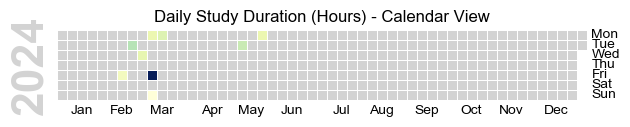

In [6]:

import calmap

# 假設你的數據表名稱為 data
data = pd.DataFrame({
    'user_sn': [8634, 8634, 8634, 8634, 8634, 314389, 314389, 316786, 316786],
    'date': pd.to_datetime(['2024-02-16', '2024-02-20', '2024-03-04', '2024-03-08', '2024-03-11', '2024-05-07', '2024-05-20', '2024-02-28', '2024-03-10']),
    'duration': pd.to_timedelta(['0 days 00:16:06', '0 days 00:39:15', '0 days 00:21:33', '0 days 02:05:00', '0 days 00:26:59', '0 days 00:35:00', '0 days 00:21:27', '0 days 00:23:37', '0 days 00:06:03'])
})

# 將學習時長轉為小時
data['duration_hours'] = data['duration'].dt.total_seconds() / 3600

# 將學習時間按日期聚合
data_by_date = data.groupby('date')['duration_hours'].sum()

# 繪製日曆圖
plt.figure(figsize=(16, 10))
calmap.calendarplot(data_by_date, cmap="YlGnBu", fillcolor="lightgray", linewidth=0.5, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title("Daily Study Duration (Hours) - Calendar View")
plt.show()


In [4]:
# 統整同個 review_sn 並統計 view_action
action_counts = dp001_review_plus.groupby(['review_sn', 'view_action']).size().unstack(fill_value=0)

# 統計每個 review_sn 的總 view_action 次數
total = action_counts.sum(axis=1).reset_index()
total.columns = ['review_sn', 'total_view_actions']

# 將 total 加到 dp001_review 裡面，靠著 review_sn 合併
dp001_review_total = dp001_review.merge(total, on='review_sn', how='left')

review_data = pd.merge(dp001_review_total, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
review_data = review_data[review_data['subject_name'].isin(['數學108', '數學'])] # 篩選數學文科目

review_data['start_time'] = pd.to_datetime(review_data['start_time']) # 轉換時間格式
review_data['end_time'] = pd.to_datetime(review_data['end_time']) # 轉換時間格式
review_data['duration'] = review_data['end_time'] - review_data['start_time'] # 計算觀看時間
review_data['date'] = review_data['start_time'].dt.date # 取得日期

# 計算每天的觀看時間
duration_per_user_per_date = review_data.groupby(['user_sn', 'date']).agg({'duration': 'sum', 'total_view_actions': 'sum'}).reset_index()
duration_per_user_per_date

,user_sn,date,duration,total_view_actions
0,8634,2024-02-16,0 days 00:16:06,12
1,8634,2024-02-20,0 days 00:39:15,169
2,8634,2024-03-04,0 days 00:21:33,9
3,8634,2024-03-08,0 days 02:05:00,33
4,8634,2024-03-11,0 days 00:26:59,30
...,...,...,...,...
624,314389,2024-05-07,0 days 00:35:00,69
625,314389,2024-05-20,0 days 00:21:27,47
626,314389,2024-05-21,0 days 00:19:17,50
627,316786,2024-02-28,0 days 00:23:37,43


In [5]:
# 計算每個 user_sn 的 total_view_actions 總和
total_view_actions_per_user = duration_per_user_per_date.groupby('user_sn')['total_view_actions'].sum().reset_index()
total_view_actions_per_user.columns = ['user_sn', 'total_view_actions_sum']

# 計算每個 user_sn 擁有的 review_sn 數量
review_counts = dp001_review.groupby('user_sn')['review_sn'].nunique().reset_index()
review_counts.columns = ['user_sn', 'review_count']
review_counts

# # 將 review_count 加到 dp001_review 裡面，靠著 user_sn 合併
total_view_actions_per_user_new = total_view_actions_per_user.merge(review_counts, on='user_sn', how='left')
# 計算平均每部影片的操作動作數量
total_view_actions_per_user_new['avg_actions_per_review'] = total_view_actions_per_user_new['total_view_actions_sum'] / total_view_actions_per_user_new['review_count']
total_view_actions_per_user_new

,user_sn,total_view_actions_sum,review_count,avg_actions_per_review
0,8634,289,50,5.780000
1,11303,161,63,2.555556
2,11312,510,44,11.590909
3,13328,185,80,2.312500
4,14503,1665,65,25.615385
5,15995,1929,76,25.381579
6,17422,7,5,1.400000
7,20034,298,82,3.634146
8,23250,411,73,5.630137
9,32737,1278,66,19.363636


# feature 從這裡看

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from datetime import timedelta
from scipy.stats import f_oneway

data = duration_per_user_per_date
scores = user_data

# 1. Convert date format and calculate the study interval for each user
data['date'] = pd.to_datetime(data['date'])
data['duration'] = pd.to_timedelta(data['duration'])

# 2. Calculate the study interval and total duration for each student
data['day_diff'] = data.groupby('user_sn')['date'].diff().dt.days
interval_std = data.groupby('user_sn')['day_diff'].std()  # Standard deviation of study intervals
total_duration = data.groupby('user_sn')['duration'].sum()  # Total study duration

# 3. Clustering: Use standard deviation and total duration as features for clustering
features = pd.DataFrame({'interval_std': interval_std, 'total_duration': total_duration})
features['total_duration'] = features['total_duration'].dt.total_seconds()  # Convert to seconds
features = features.merge(total_view_actions_per_user_new, on='user_sn', how='left') # Merge total view actions

# Remove samples with missing values
features = features.dropna()
features



,user_sn,interval_std,total_duration,total_view_actions_sum,review_count,avg_actions_per_review
0,8634,9.633276,14792.0,289,50,5.780000
1,11303,8.211780,13961.0,161,63,2.555556
2,11312,23.334524,3748.0,510,44,11.590909
3,13328,8.368260,16481.0,185,80,2.312500
4,14503,7.018725,36012.0,1665,65,25.615385
5,15995,6.935746,52504.0,1929,76,25.381579
7,20034,9.840635,20257.0,298,82,3.634146
8,23250,7.501515,11918.0,411,73,5.630137
9,32737,5.294098,24644.0,1278,66,19.363636
11,38614,9.093531,34269.0,2320,67,34.626866


# kmeans

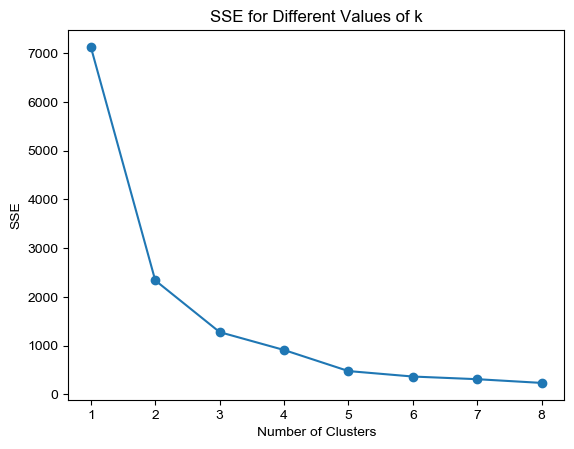

各群 math_score 均值：
 cluster
0    44.923077
1    40.842105
2    54.666667
3    28.000000
4    57.666667
Name: math_score, dtype: float64
各群 math_score 中位數：
 cluster
0    44.0
1    40.0
2    48.0
3    28.0
4    62.0
Name: math_score, dtype: float64
各群 math_score 標準差：
 cluster
0    15.418936
1    13.635180
2    15.143756
3          NaN
4    17.095099
Name: math_score, dtype: float64
各群 math_score 數量：
 cluster
0    13
1    19
2     3
3     1
4    12
Name: math_score, dtype: int64
F-statistic: 2.9140047434761143, P-value: 0.0321652850763568
There is a significant difference in math scores between different clusters.


In [8]:

SSE = []  # Sum of Squared Error
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    features['cluster'] = kmeans.fit_predict(features[['interval_std', 'avg_actions_per_review']])
    features
    SSE.append(kmeans.inertia_)
y_pos  = np.arange(1,9)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE for Different Values of k')
plt.plot(y_pos , SSE, 'o-')
plt.show()
# Use K-means for clustering into two categories
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(features[['interval_std', 'avg_actions_per_review']])

# Merge the cluster labels with the user data to get math scores
result = features.merge(user_data[['user_sn', 'math_score']], on='user_sn', how='left')

cluster_means = result.groupby('cluster')['math_score'].mean()
print("各群 math_score 均值：\n", cluster_means)
cluster_medians = result.groupby('cluster')['math_score'].median()
print("各群 math_score 中位數：\n", cluster_medians)
cluster_std = result.groupby('cluster')['math_score'].std()
print("各群 math_score 標準差：\n", cluster_std)
cluster_counts = result.groupby('cluster')['math_score'].count()
print("各群 math_score 數量：\n", cluster_counts)

# Use ANOVA to test whether there are significant differences in math_score between different clusters
grouped_scores = [group['math_score'].values for name, group in result.groupby('cluster')]
f_stat, p_value = f_oneway(*grouped_scores)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in math scores between different clusters.")
else:
    print("There is no significant difference in math scores between different clusters.")


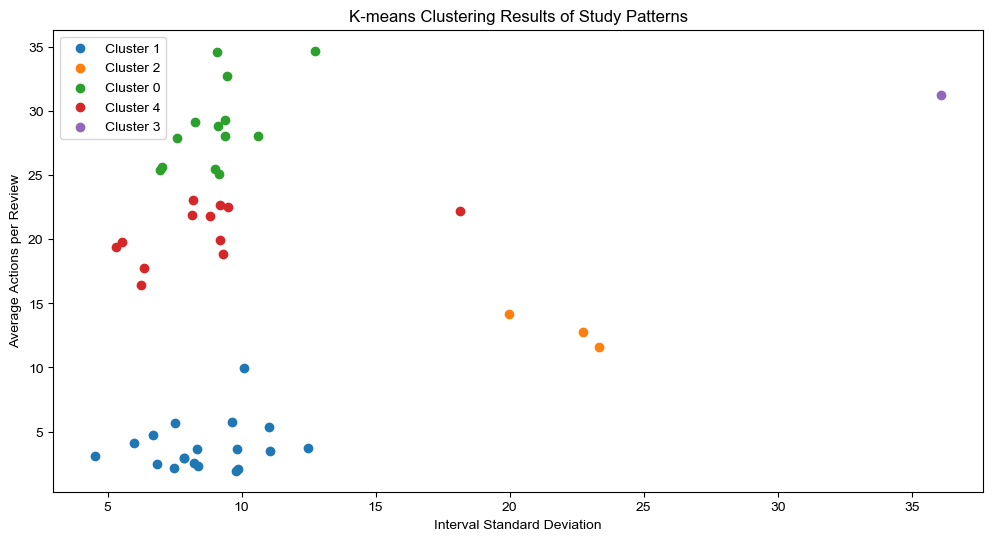

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

In [10]:
# 繪製 K-means 分群結果
plt.figure(figsize=(12, 6))
for cluster in features['cluster'].unique():
    cluster_data = features[features['cluster'] == cluster]
    # plt.scatter(cluster_data['interval_std'], cluster_data['total_duration'], label=f'Cluster {cluster}')
    plt.scatter(cluster_data['interval_std'], cluster_data['avg_actions_per_review'], label=f'Cluster {cluster}')
    plt.xlabel('Interval Standard Deviation')
    plt.ylabel('Average Actions per Review')
    plt.title('K-means Clustering Results of Study Patterns')
    plt.legend()
plt.show()

# new_features = features.merge(user_data[['user_sn', 'math_score']], on='user_sn', how='left')
# new_features
# # 繪製各 cluster 的 math_score 箱形圖
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='math_score', data=new_features)
plt.xlabel('Cluster')
plt.ylabel('Math Score')
plt.title('Math Score Distribution Across Clusters')
plt.show()

# DBSCAN

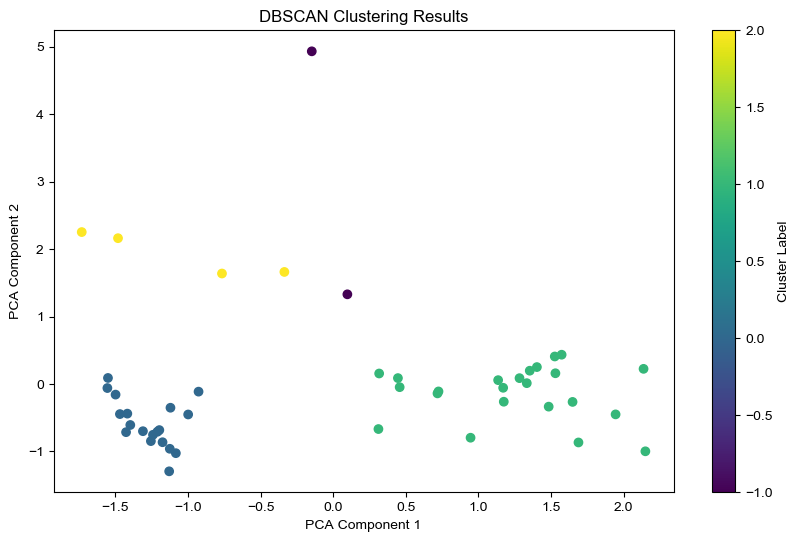

In [223]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 將資料載入 DataFrame
data = features

# 選取要分群的特徵
# X = data[['interval_std', 'total_duration', 'total_view_actions_sum', 'review_count', 'avg_actions_per_review']]
X = data[['interval_std', 'total_duration', 'avg_actions_per_review']]

# 標準化資料
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練 DBSCAN 模型
dbscan = DBSCAN(eps=1, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

# 將分群結果加到資料表中
data['cluster'] = clusters

# 視覺化分群結果（使用 PCA 降維至 2 維）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.colorbar(label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering Results')
plt.show()


# 檢視DBSCAN

各群 math_score 均值：
 cluster
-1    42.000000
 0    40.842105
 1    51.478261
 2    50.000000
Name: math_score, dtype: float64


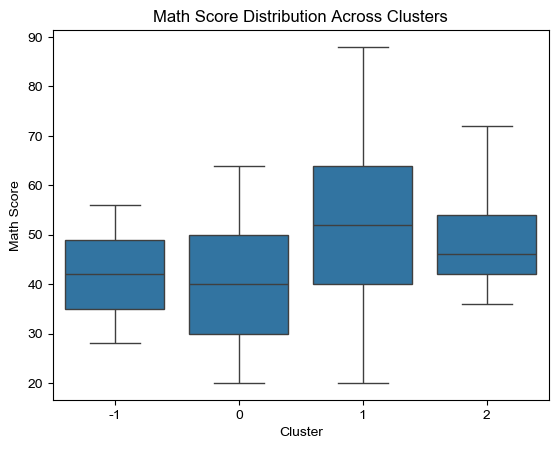

ANOVA 檢定結果： F_onewayResult(statistic=1.6438323088412394, pvalue=0.19296804494986097)


In [224]:
import seaborn as sns
import scipy.stats as stats

# 將 user_data 中的 math_score 加入到 data 中
data = data.merge(user_data[['user_sn', 'math_score']], on='user_sn', how='left')

# 假設 `data` 中新增了一個 math_score 欄位
# 比較各個 cluster 的 math_score 均值
cluster_means = data.groupby('cluster')['math_score'].mean()
print("各群 math_score 均值：\n", cluster_means)

# 視覺化 math_score 在各個 cluster 的分佈情況
sns.boxplot(x='cluster', y='math_score', data=data)
plt.xlabel('Cluster')
plt.ylabel('Math Score')
plt.title('Math Score Distribution Across Clusters')
plt.show()

# 進行 ANOVA 檢定
anova_result = stats.f_oneway(*(data[data['cluster'] == c]['math_score'] for c in data['cluster'].unique()))
print("ANOVA 檢定結果：", anova_result)


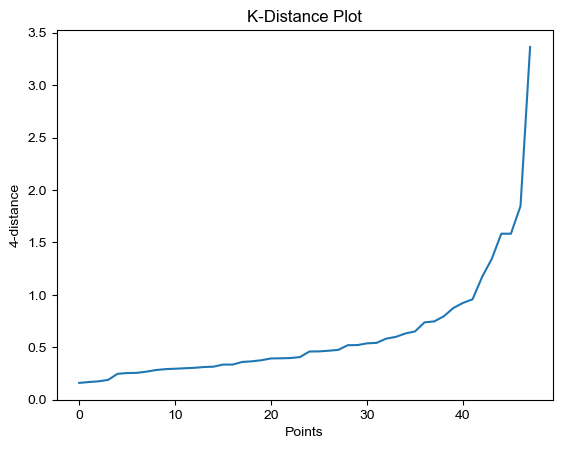

In [214]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 計算每個點的 k 距離（例如 k=4）
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# 繪製 k 距離圖
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel(f"{k}-distance")
plt.title("K-Distance Plot")
plt.show()


In [181]:
import seaborn as sns
import scipy.stats as stats

# 假設 `data` 中新增了一個 math_score 欄位
# 比較各個 cluster 的 math_score 均值
cluster_means = data.groupby('cluster')['math_score'].mean()
print("各群 math_score 均值：\n", cluster_means)

# 視覺化 math_score 在各個 cluster 的分佈情況
sns.boxplot(x='cluster', y='math_score', data=data)
plt.xlabel('Cluster')
plt.ylabel('Math Score')
plt.title('Math Score Distribution Across Clusters')
plt.show()

# 進行 ANOVA 檢定
anova_result = stats.f_oneway(*(data[data['cluster'] == c]['math_score'] for c in data['cluster'].unique()))
print("ANOVA 檢定結果：", anova_result)


KeyError: 'Column not found: math_score'

In [57]:
import statsmodels.api as sm

# 假設每個學生有學習模式和總學習時間
result['study_pattern'] = result['study_pattern'].map({'Distributed': 1, 'Massed': 0})
X = result[['study_pattern', 'total_duration']]
y = result['math_score']

# 加入常數項
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             math_score   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.040
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.142
Time:                        15:26:03   Log-Likelihood:                -199.61
No. Observations:                  48   AIC:                             405.2
Df Residuals:                      45   BIC:                             410.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             58.8655     10.794      5.

In [49]:
def relationship_between_during_time_and_score_rate(data, subject_name, subject_score): # 繪製作答時間與分數之間的關係
    # subject_data = data[data['subject_name'].isin([subject_name])]
    subject_data = data[data['subject_name'].isin(subject_name)] # 篩選科目
    subject_data = subject_data.assign(at_count=subject_data['binary_res'].apply(lambda x: x.count('@') / 2)) # 計算答題數

    total_during_time = subject_data.groupby('user_sn').agg({'during_time': 'sum', 'at_count': 'sum', 'score_rate': 'mean'}).reset_index() # 計算總答題數與總作答時間
    total_during_time['time_per_question'] = total_during_time['during_time'] / total_during_time['at_count'] # 計算平均每題作答時間
    total_during_time = total_during_time.merge(user_data[['user_sn', subject_score]], on='user_sn', how='left') # 合併分數資料
    
    total_during_time = total_during_time[total_during_time['during_time'] < 3000] # 篩選作答時間小於1200的資料
    return total_during_time

    # X = total_during_time['during_time']
    # y = total_during_time['score_rate']
    # X = sm.add_constant(X)  # 增加截距項
    # model = sm.OLS(y, X).fit()
    # print(model.summary()) # 顯示迴歸結果
    
    # plt.scatter(total_during_time['during_time'], total_during_time['score_rate']) # 繪製散點圖
    # plt.xlabel('Total During Time')
    # plt.ylabel('Score Rate')
    # plt.title(f'Relationship between During Time and Score Rate in {subject_name}')
    # plt.show()

In [54]:
merged_data = pd.merge(dp001_prac, user_data, on='user_sn', how='left') # 合併兩個 DataFrame
filtered_data = merged_data[merged_data['subject_name'].isin(['國語文108', '數學108', '數學', '英語108', '國語文'])]
# math_score_rate = relationship_between_during_time_and_score_rate(merged_data, ['國語文108', '國語文'], 'chinese_score')
math_score_rate = relationship_between_during_time_and_score_rate(merged_data, ['數學108', '數學'], 'math_score')
math_score_rate

,user_sn,during_time,at_count,score_rate,time_per_question,math_score
0,4561,502,62.0,93.333333,8.096774,56
2,11303,752,60.0,43.333333,12.533333,20
3,11312,711,38.0,86.842105,18.710526,72
4,13328,509,82.0,65.853659,6.207317,44
5,14503,567,8.0,50.000000,70.875000,20
7,17422,631,20.0,85.000000,31.550000,60
8,20034,1173,54.0,44.444444,21.722222,60
9,23250,1348,88.0,68.181818,15.318182,36
10,32737,352,14.0,100.000000,25.142857,88
11,38371,134,6.0,83.333333,22.333333,24
